Vorverarbeitete Daten wurden gespeichert unter ..\data\processed_data\preprocessed_data.csv


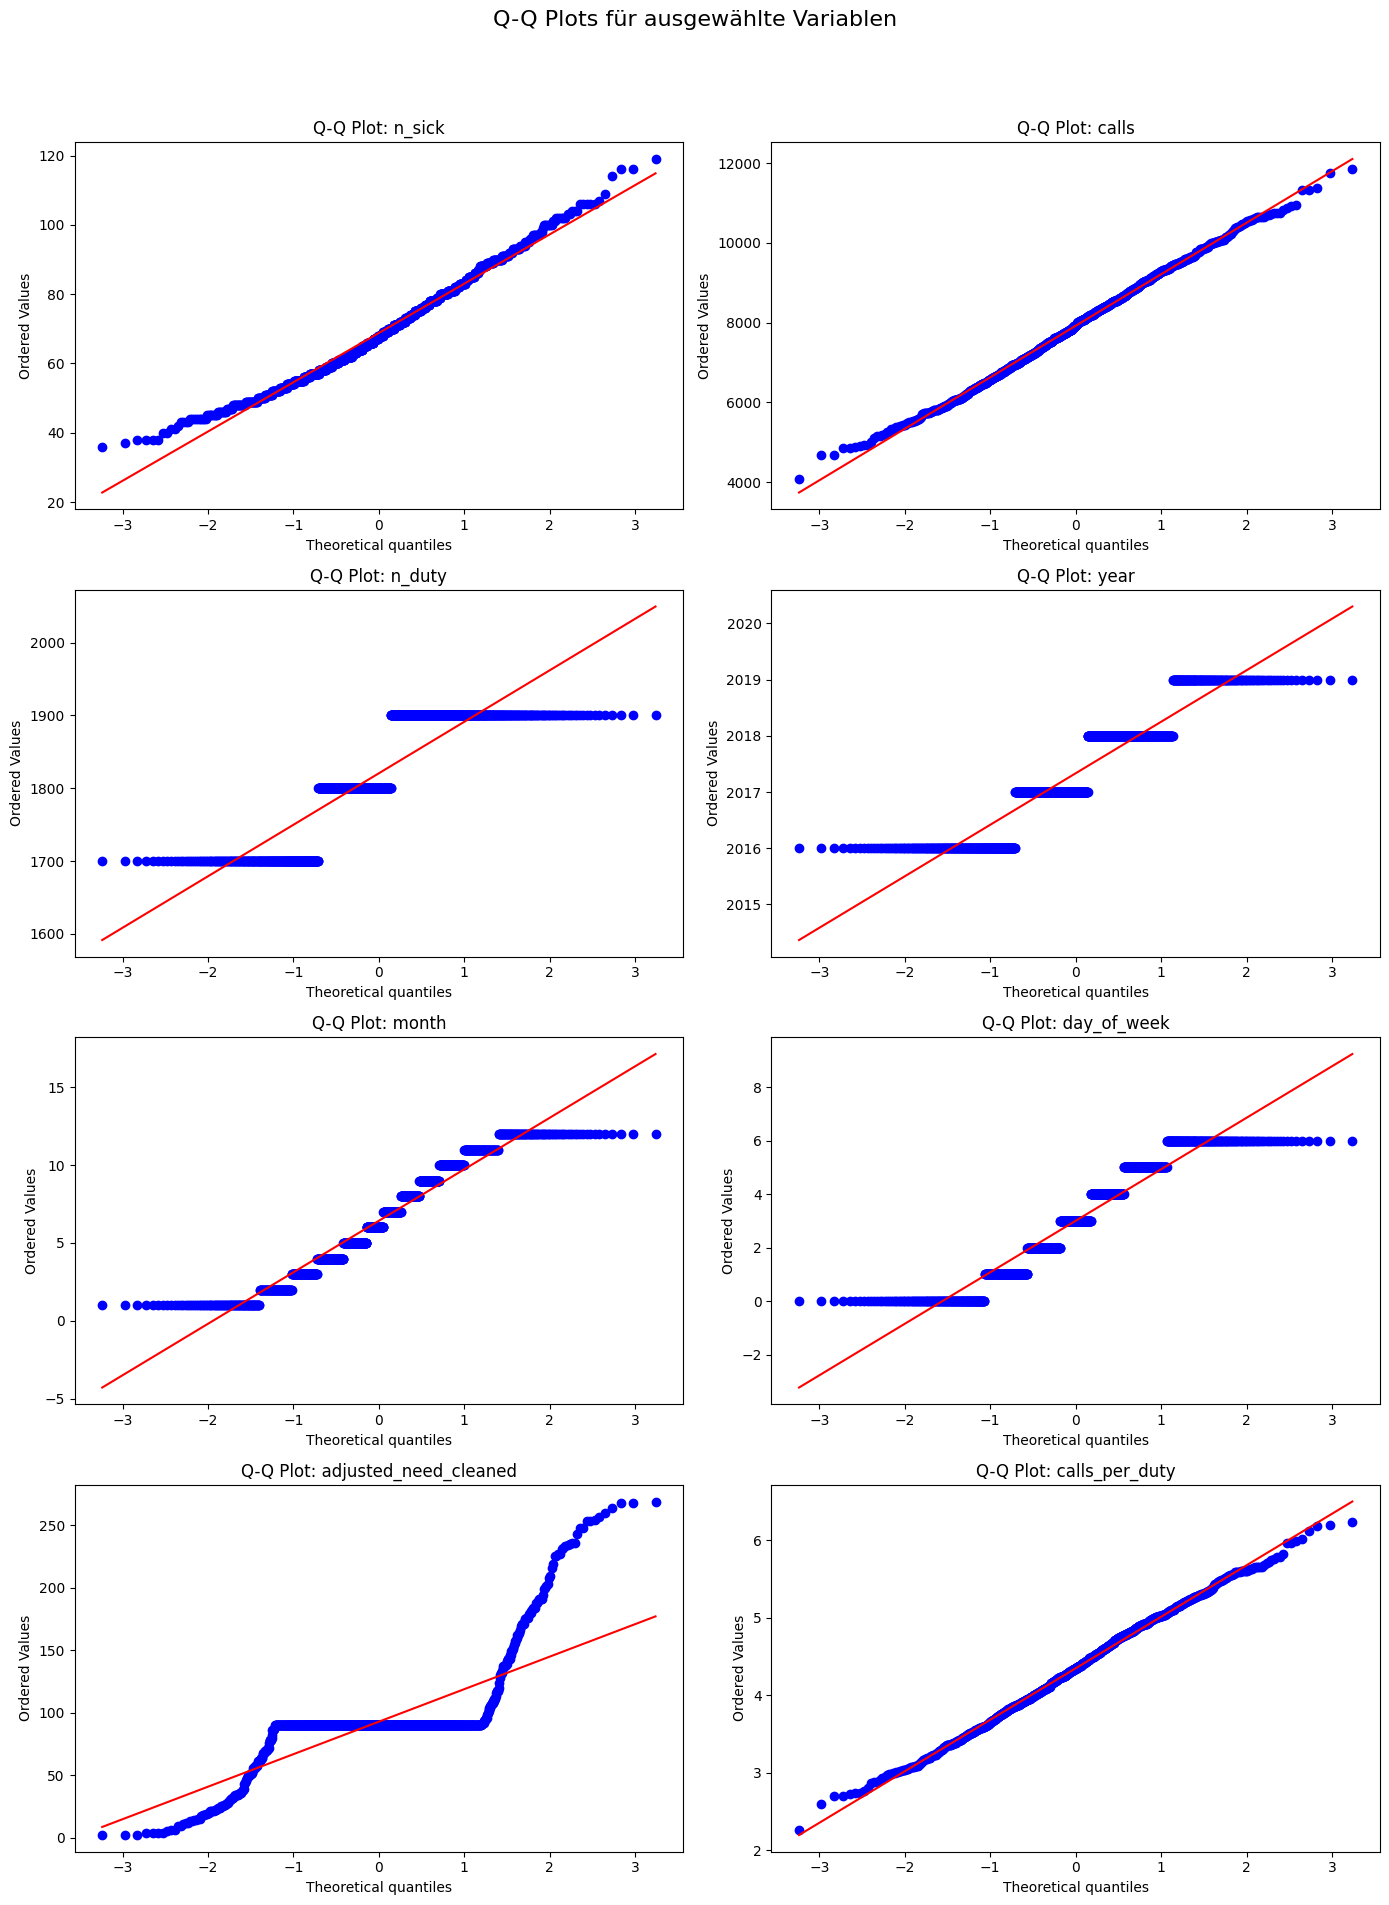

Deskriptive Statistiken wurden unter '..isualizations\descriptive_statistics.csv' gespeichert.
            n_sick         calls       n_duty   n_sby     sby_need  \
count  1152.000000   1152.000000  1152.000000  1152.0  1152.000000   
mean     68.808160   7919.531250  1820.572917    90.0    34.718750   
std      14.293942   1290.063571    80.086953     0.0    79.694251   
min      36.000000   4074.000000  1700.000000    90.0     0.000000   
25%      58.000000   6978.000000  1800.000000    90.0     0.000000   
50%      68.000000   7932.000000  1800.000000    90.0     0.000000   
75%      78.000000   8827.500000  1900.000000    90.0    12.250000   
max     119.000000  11850.000000  1900.000000    90.0   555.000000   

            dafted         year        month  day_of_week  adjusted_need  \
count  1152.000000  1152.000000  1152.000000  1152.000000    1152.000000   
mean     16.335938  2017.333333     6.424479     3.002604     101.046875   
std      53.394089     0.977594     3.394101 

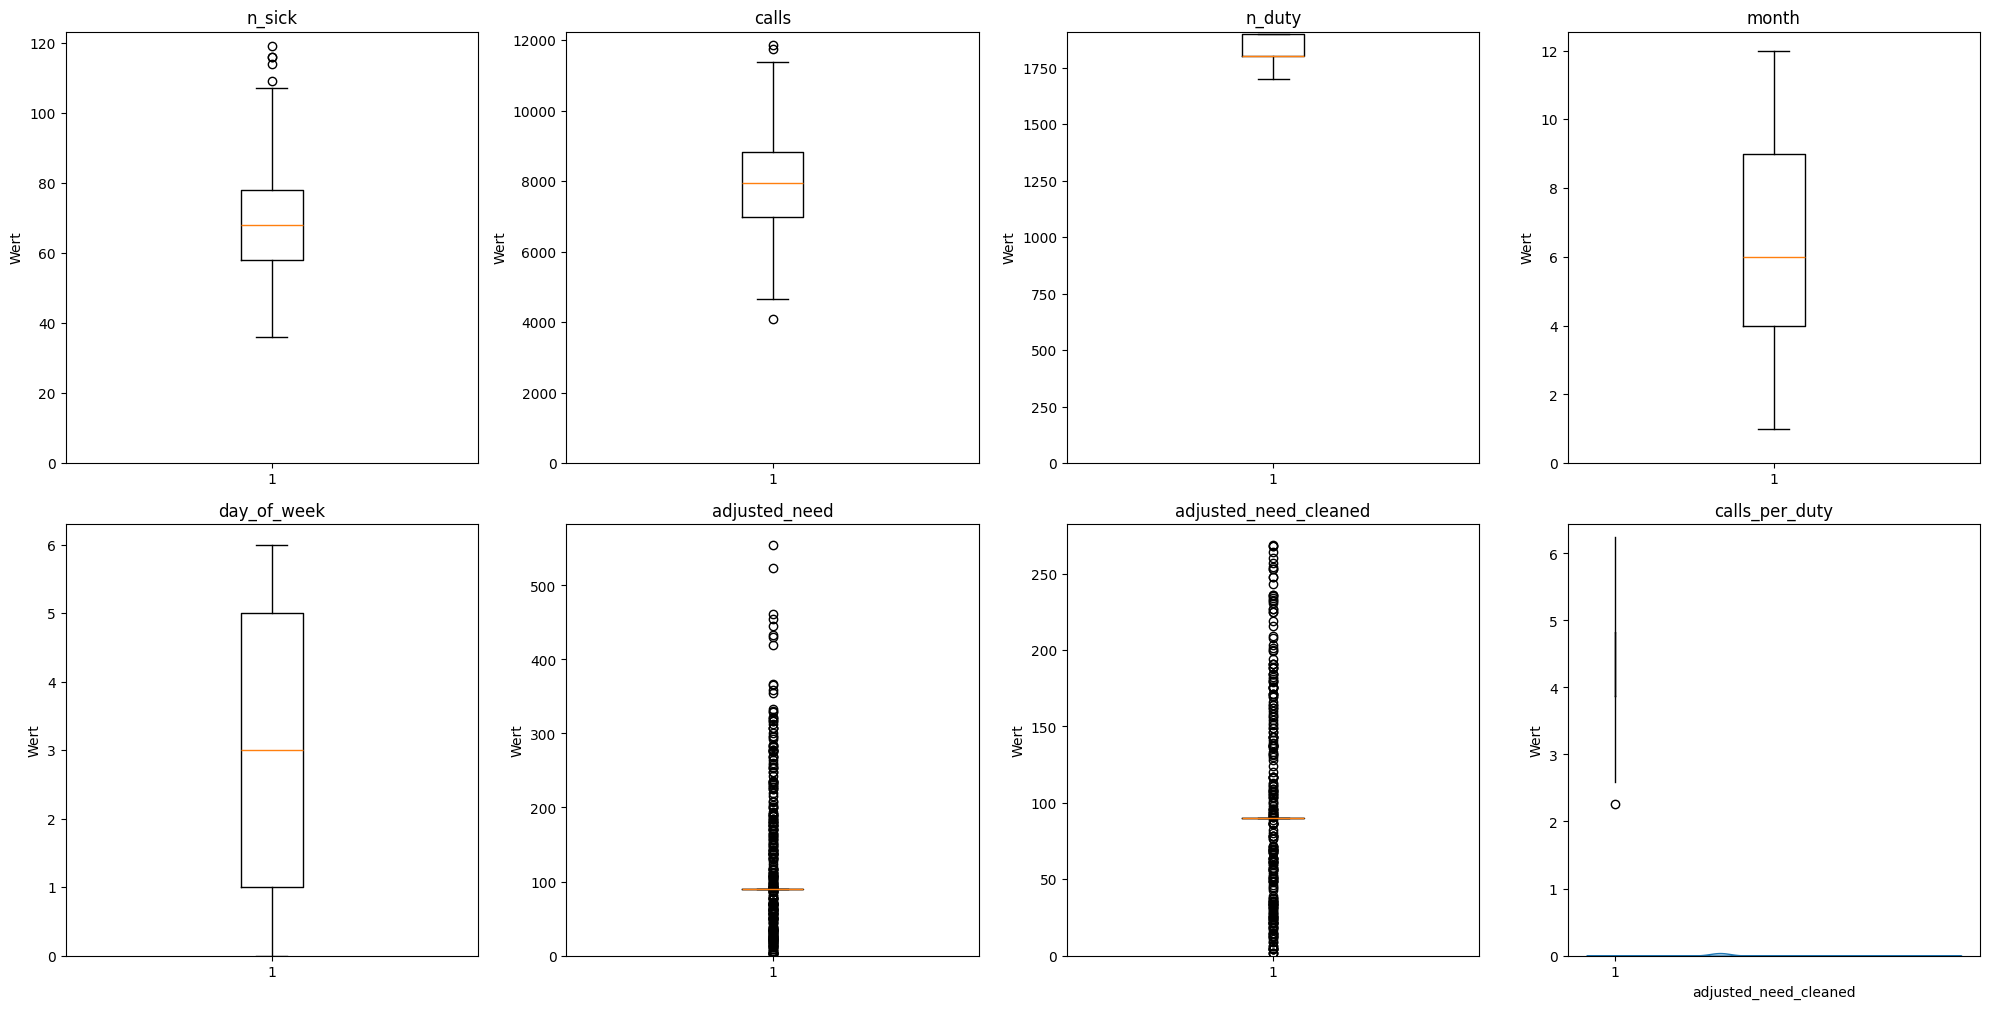

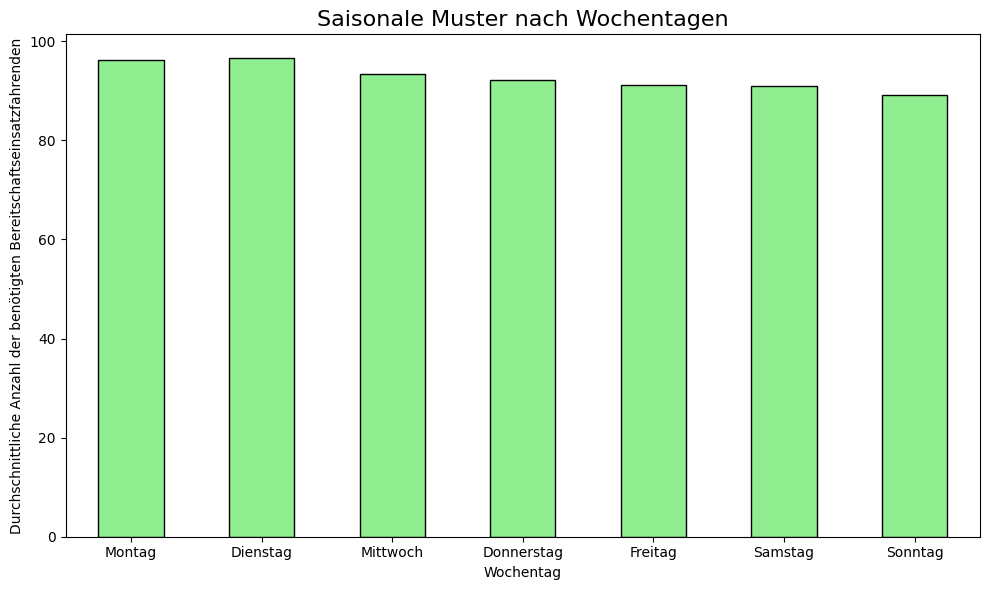

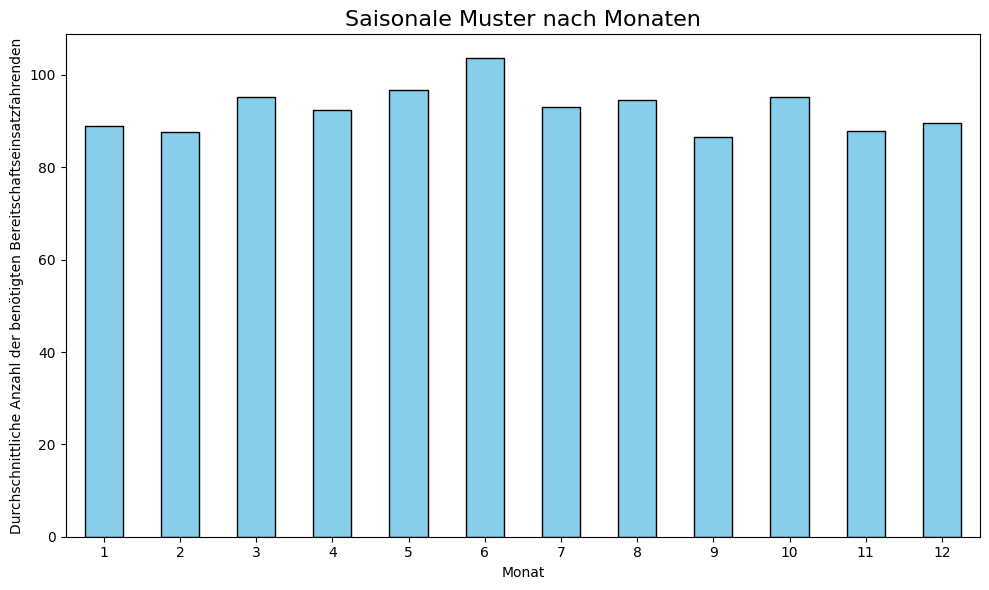

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

def preprocess_data(data):
    # Datum in Komponenten zerlegen
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek

    # Kategorisierung der Jahreszeiten
    data['season'] = data['month'].apply(lambda month: 
                                         'Spring' if 3 <= month <= 5 
                                         else 'Summer' if 6 <= month <= 8 
                                         else 'Autumn' if 9 <= month <= 11 
                                         else 'Winter')

    # One-Hot-Encoding für die Jahreszeiten
    data = pd.get_dummies(data, columns=['season'], drop_first=False)

    # Berechnung der adjusted_need
    data['adjusted_need'] = data['sby_need'].apply(calculate_adjusted_need)

    # Neue Variable: Anzahl der Anrufe pro Bereitschaft pro Tag
    data['calls_per_duty'] = (data['calls'] / data['n_duty']) 

    # Zyklische Transformation von Zeitvariablen (Monat und Wochentag)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

    # Gleitende Durchschnitte
    data['avg_calls_last_30_days'] = data['calls'].rolling(window=30, min_periods=1).mean()
    data['avg_sick_last_30_days'] = data['n_sick'].rolling(window=30, min_periods=1).mean()

    # Entfernen der unnötigen Spalten
    data = data.drop(columns=['Unnamed: 0', 'date'])

    return data

def calculate_adjusted_need(sby_need):
    if sby_need > 0 and sby_need < 90:
        return sby_need
    elif sby_need == 0:  # Bedarf war genau gedeckt --> 90 Fahrer ausreichend
        return 90
    else:  # sby_need >= 90
        return sby_need

def remove_outliers_by_zscore(data, column, threshold=3):
    # Berechnung des Z-Scores für die angegebene Spalte
    mean_value = np.mean(data[column])
    std_value = np.std(data[column])
    data['z_score'] = (data[column] - mean_value) / std_value

    # Indizes der Ausreißer basierend auf dem Z-Score
    ausreißer_index = data[(data['z_score'] > threshold) | (data['z_score'] < -threshold)].index
    
    # Speichern der Ausreißer in einer neuen Spalte
    data['outlier'] = np.where(data['z_score'].abs() > threshold, True, False)

    # Füllt Ausreißer mit dem Median und speichert die bereinigten Werte in einer neuen Spalte
    median_value = np.median(data[column])

    # Erstellen einer Kopie der Spalte mit den Originalwerten
    data['adjusted_need_cleaned'] = data[column].copy()  # Originalwerte speichern

    # Bereinigen der Ausreißer
    data.loc[ausreißer_index, 'adjusted_need_cleaned'] = median_value  # Nur bereinigte Spalte ändern

    # Anzahl der Ausreißer speichern
    num_outliers = len(ausreißer_index)

    # Alle Ausreißerzeilen erfassen
    outlier_info = data.loc[ausreißer_index].copy()
    outlier_info = outlier_info[['outlier', column, 'adjusted_need_cleaned'] + data.columns.tolist()]  # Füge andere Spalten hinzu
    outlier_info['Number of Outliers'] = num_outliers

    # CSV-Datei mit Ausreißerinformationen speichern
    outlier_info.to_csv(r"..\visualizations\outlier_info.csv", index=False)

    # Entferne die z_score-Spalte aus den Daten
    data.drop(columns=['z_score'], inplace=True)
    
    # Rückgabe des modifizierten DataFrames
    return data

def analyze_data(data):
    # Korrelationsanalyse
    corr_variables = ['n_sick', 'calls', 'n_duty', 'year', 'month', 'adjusted_need_cleaned', 'day_of_week', 
                      'day_of_week_sin', 'day_of_week_cos', 'avg_calls_last_30_days', 'avg_sick_last_30_days', 
                      'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter', 'calls_per_duty']
    correlation_matrix = data[corr_variables].corr()

    # Visualisierung der Korrelationsmatrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
    plt.title('Korrelationsmatrix der wichtigsten Variablen', fontsize=16)
    plt.tight_layout()
    plt.savefig(r"..\visualizations\korrelationsmatrix_features.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Q-Q-Plots für ausgewählte Variablen
    variables = ['n_sick', 'calls', 'n_duty', 'year', 'month', 'day_of_week', 'adjusted_need_cleaned', 'calls_per_duty']
    n_cols = 2
    n_rows = (len(variables) + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
    fig.suptitle('Q-Q Plots für ausgewählte Variablen', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(variables):
        stats.probplot(data[col], dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot: {col}')

    # Die unbenutzten Plots entfernen
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(r"..\visualizations\qq_plots_ausgewaehlter_variablen.png", format='png', dpi=300)
    plt.show()

def descriptive_statistics(data):
    # Variablen zur Analyse
    variables = ['n_sick', 'calls', 'n_duty', 'month', 'day_of_week', 'adjusted_need', 'adjusted_need_cleaned', 'calls_per_duty']

    # Anzahl der Variablen
    num_vars = len(variables)

    # Dynamisch die Anzahl der Zeilen und Spalten bestimmen
    n_cols = 4
    n_rows = (num_vars + n_cols - 1) // n_cols  # Rundet auf die nächste ganze Zahl

    # Eine Figur mit Subplots für jede Variable
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=False)  # Erhöhte Höhe für größere Boxplots
    axes = axes.flatten()  # Um einfacher auf die Achsen zugreifen zu können

    # Ein Boxplot für jede Variable
    for i, var in enumerate(variables):
        ax = axes[i]  # Zugriff auf die entsprechende Achse
        ax.boxplot(data[var].dropna())
        ax.set_title(var)
        ax.set_ylabel('Wert')
        ax.set_ylim(bottom=0)  # Setze den unteren Y-Achsenbereich, falls sinnvoll

    # Wenn es unbenutzte Plots gibt, entferne sie
    for j in range(num_vars, len(axes)):
        fig.delaxes(axes[j])

    # Anpassen des Layouts
    plt.tight_layout()

    # Speichern
    plt.savefig(r"..\visualizations\boxplots_cleaned.png", dpi=300, bbox_inches='tight')

    # Deskriptive Statistiken
    results = pd.DataFrame({
        'Variable': pd.Series(dtype='str'),
        'Shapiro_Statistic': pd.Series(dtype='float'),
        'Shapiro_p_value': pd.Series(dtype='float'),
        'Mean': pd.Series(dtype='float'),
        'Std': pd.Series(dtype='float'),
        'Min': pd.Series(dtype='float'),
        'Max': pd.Series(dtype='float'),
        'Schiefe': pd.Series(dtype='float'),
        'Kurtosis': pd.Series(dtype='float')
    })

    for col in variables:
        # Shapiro-Wilk Test
        stat, p = stats.shapiro(data[col])

        # Deskriptive Statistiken
        desc = data[col].describe()
        skew = data[col].skew()
        kurtosis = data[col].kurtosis()

        # Ergebnisse zum DataFrame hinzufügen
        new_row = pd.DataFrame({
            'Variable': [col],
            'Shapiro_Statistic': [round(stat, 2)],
            'Shapiro_p_value': [round(p, 2)],
            'Mean': [round(desc['mean'], 2)],
            'Std': [round(desc['std'], 2)],
            'Min': [round(desc['min'], 2)],
            'Max': [round(desc['max'], 2)],
            'Schiefe': [round(skew, 2)],
            'Kurtosis': [round(kurtosis, 2)]
        })
        results = pd.concat([results, new_row], axis=0, ignore_index=True)

    # CSV-Datei speichern
    results.to_csv(r"..\visualizations\descriptive_statistics.csv", index=False)
    print(f"Deskriptive Statistiken wurden unter '..\visualizations\descriptive_statistics.csv' gespeichert.")

def seasonal_analysis(data):
    # Wöchentliche Muster der benötigten Bereitschaftseinsatzfahrenden
    weekly_data = data.groupby(data['day_of_week'])['adjusted_need_cleaned'].mean()

    plt.figure(figsize=(10, 6))
    weekly_data.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.xlabel('Wochentag')
    plt.ylabel('Durchschnittliche Anzahl der benötigten Bereitschaftseinsatzfahrenden')
    plt.title('Saisonale Muster nach Wochentagen', fontsize=16)
    plt.xticks(ticks=range(7), labels=['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'], rotation=0)
    plt.tight_layout()
    plt.savefig(r"..\visualizations\seisonale_muster_wochen_adjusted_need_cleaned.png")
    plt.show()

    # Monatliche Muster der benötigten Bereitschaftseinsatzfahrenden
    monthly_data = data.groupby(data['month'])['adjusted_need_cleaned'].mean()

    plt.figure(figsize=(10, 6))
    monthly_data.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Monat')
    plt.ylabel('Durchschnittliche Anzahl der benötigten Bereitschaftseinsatzfahrenden')
    plt.title('Saisonale Muster nach Monaten', fontsize=16)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(r"..\visualizations\monatliche_muster_adjusted_need_cleaned.png", format='png', dpi=300)
    plt.show()


def main():
    # Daten einlesen
    data_path = r"..\data\raw_data\sickness_table.csv"
    data = pd.read_csv(data_path)

    # Vorverarbeitung der Daten
    data = preprocess_data(data)

    # Ausreißer entfernen
    data = remove_outliers_by_zscore(data, 'adjusted_need', threshold=3)

    # Speichern der vorverarbeiteten Daten
    processed_data_path = r"..\data\processed_data\preprocessed_data.csv"
    data.to_csv(processed_data_path, index=False)
    print(f"Vorverarbeitete Daten wurden gespeichert unter {processed_data_path}")

    # Analysieren der Daten
    analyze_data(data)

    # Deskriptive Statistiken und Normalitätstests
    descriptive_statistics(data)

    # Zeigt grundlegende Informationen und eine statistische Zusammenfassung der Daten an.
    print(data.describe(), '\n')

    # Dichteplot
    sns.kdeplot(data['adjusted_need_cleaned'], fill=True)  # Bereinigte Werte verwenden
    #plt.show()

    # Saisonale Analysen (Woche, Monat)
    seasonal_analysis(data)

if __name__ == "__main__":
    main()
